# Audio Process
This notebooks needs the podcastmix subset to be in the same directory of this notebook. If you run all the cells from FinalProject_dataset_creation notebook the dataset should already be in the required location and you skip the cell below and go directly to the "!pip install requirements" cell. However, if you wanted to save some time and directly download the dataset, without running the FinalProject_dataset_creation notebook, you must run the cell below:

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# %cd /content/drive/MyDrive/Colab Notebooks/MIR/FinalProject

In [2]:
# download and unzip the Podcastmix Subset, if you did not run the FinalProject_dataset_creation notebook
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1XesmeGRCAIsGEC0_RRZdSA4bkJ8oJZvY' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1XesmeGRCAIsGEC0_RRZdSA4bkJ8oJZvY" -O podcastmix-subset.zip && rm -rf /tmp/cookies.txt
!unzip podcastmix-subset.zip

--2021-03-26 21:17:36--  https://docs.google.com/uc?export=download&confirm=iCSb&id=1XesmeGRCAIsGEC0_RRZdSA4bkJ8oJZvY
Resolving docs.google.com (docs.google.com)... 2a00:1450:4003:802::200e, 172.217.17.14
Connecting to docs.google.com (docs.google.com)|2a00:1450:4003:802::200e|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0g-0c-docs.googleusercontent.com/docs/securesc/hgndgt5kk751lrdebn56cm4mbs10klac/k70a0afrf1hapsg4qvesar7to7bv8php/1616789850000/12540488418707948774/04172262663714881430Z/1XesmeGRCAIsGEC0_RRZdSA4bkJ8oJZvY?e=download [following]
--2021-03-26 21:17:36--  https://doc-0g-0c-docs.googleusercontent.com/docs/securesc/hgndgt5kk751lrdebn56cm4mbs10klac/k70a0afrf1hapsg4qvesar7to7bv8php/1616789850000/12540488418707948774/04172262663714881430Z/1XesmeGRCAIsGEC0_RRZdSA4bkJ8oJZvY?e=download
Resolving doc-0g-0c-docs.googleusercontent.com (doc-0g-0c-docs.googleusercontent.com)... 2a00:1450:4003:808::2001, 142.250.184.1
Connecting 

# Install required packages

In [3]:
!pip install pytorch-lightning
!pip install asteroid
!pip install ffmpeg
!pip install torchaudio

# Analize data

## Speaker dataset

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
train_data = pd.read_csv('podcastmix/metadata/train/speech.csv')
train_data['subset'] = 'train'
val_data = pd.read_csv('podcastmix/metadata/val/speech.csv')
val_data['subset'] = 'val'
test_data = pd.read_csv('podcastmix/metadata/test/speech.csv')
test_data['subset'] = 'test'
data = pd.concat([train_data, val_data, test_data], ignore_index = True)
data.head()

,speech_ID,speaker_id,speaker_age,speaker_gender,speaker_accent,speech_path,length,subset
0,377_mic2,p227,38,M,English,podcastmix/train/speech/p227_377_mic2.mp3,120966,train
1,283_mic2,p229,23,F,English,podcastmix/train/speech/p229_283_mic2.mp3,116336,train
2,266_mic2,p229,23,F,English,podcastmix/train/speech/p229_266_mic2.mp3,110559,train
3,268_mic1,p225,23,F,English,podcastmix/train/speech/p225_268_mic1.mp3,141693,train
4,071_mic2,p234,22,F,Scottish,podcastmix/train/speech/p234_071_mic2.mp3,122113,train


In [6]:
data.groupby("subset").mean()

,speaker_age,length
subset,,
test,24.051144,149290.433378
train,24.186469,147465.290306
val,24.193809,148321.829071


In [7]:
data.groupby("subset").std()

,speaker_age,length
subset,,
test,4.631728,58965.230168
train,4.772300,53536.207217
val,4.720502,55351.644405


In [8]:
data.groupby("speaker_accent").count()

,speech_ID,speaker_id,speaker_age,speaker_gender,speech_path,length,subset
speaker_accent,,,,,,,
English,6714,6714,6714,6714,6714,6714,6714
Scottish,714,714,714,714,714,714,714


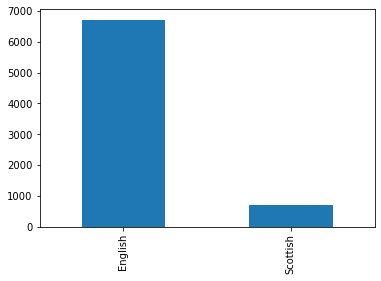

In [9]:
data['speaker_accent'].value_counts().plot(kind='bar')

Text(0, 0.5, 'Gender frequency')

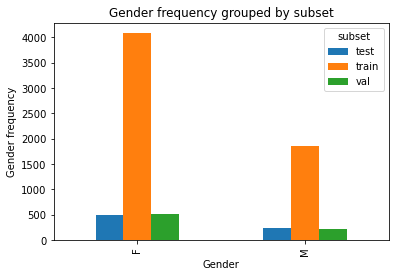

In [10]:
%matplotlib inline
pd.crosstab(data.speaker_gender, data.subset).plot(kind="bar")
plt.title("Gender frequency grouped by subset")
plt.xlabel("Gender")
plt.ylabel("Gender frequency")

Text(0, 0.5, 'Frequency')

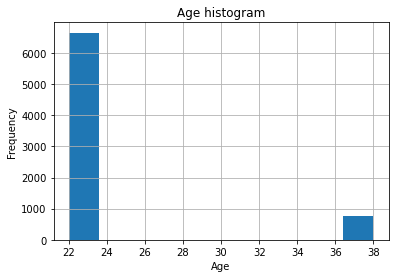

In [11]:
%matplotlib inline
data.speaker_age.hist()
plt.title("Age histogram")
plt.xlabel("Age")
plt.ylabel("Frequency")

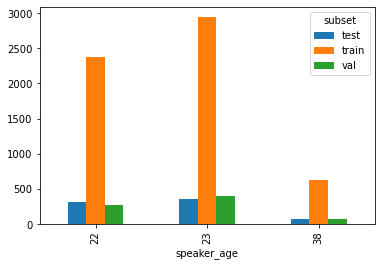

In [12]:
pd.crosstab(data.speaker_age, data.subset).plot(kind="bar")

# For the music:

In [13]:
# load music
train_data = pd.read_csv('podcastmix/metadata/train/music.csv')
train_data['subset'] = 'train'
val_data = pd.read_csv('podcastmix/metadata/val/music.csv')
val_data['subset'] = 'val'
test_data = pd.read_csv('podcastmix/metadata/test/music.csv')
test_data['subset'] = 'test'
data_csv = pd.concat([train_data, val_data, test_data], ignore_index = True)
data_csv.head()

,music_ID,jamendo_id,name,artist_name,album_name,license_ccurl,releasedate,music_path,length,subset
0,13347,13347,Du Rififi a Noubaka,Stan-X,Stan-X,http://creativecommons.org/licenses/by-nc-sa/2...,2006-05-14,podcastmix/train/music/13347.mp3,12636767,train
1,431415,431415,Briccialdi - Duo Concertante part. 2,Carlo Tamponi,Classical Music - Donizzetti Rossini: Flute ch...,http://creativecommons.org/licenses/by-nc-nd/3.0/,2009-09-21,podcastmix/train/music/431415.mp3,6940767,train
2,183411,183411,Chill Out,Nate Maingard,As I Am,http://creativecommons.org/licenses/by-nc-nd/3.0/,2008-06-23,podcastmix/train/music/183411.mp3,12376400,train
3,1336202,1336202,Letters Home,Grégoire Lourme,1914-1918 Never Forget,http://creativecommons.org/licenses/by-nc-nd/3.0/,2016-04-15,podcastmix/train/music/1336202.mp3,10065252,train
4,944926,944926,lady Lent,Ton,Naïve waves,http://creativecommons.org/licenses/by-nc-nd/3.0/,2012-06-14,podcastmix/train/music/944926.mp3,7243734,train


In [14]:
import os
import json
import requests

In [22]:
# the next cell (not this one) queries the Jamendo API to obtain the relevant tags
# If you dont want to wait you can run this cell, which the previously
# downloaded tags were saved in a json file and uploaded to drive for 
# fast experimentation
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=103bQlPPX8Rg6N1T_dRqKKrB0xPM309z8' -O 'jamendo_tags_metadata.json'

--2021-03-26 21:21:31--  https://docs.google.com/uc?export=download&id=103bQlPPX8Rg6N1T_dRqKKrB0xPM309z8
Resolving docs.google.com (docs.google.com)... 2a00:1450:4003:80d::200e, 142.250.200.78
Connecting to docs.google.com (docs.google.com)|2a00:1450:4003:80d::200e|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-2s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/tmtna75jvtvpeaiv5uht7bncuu4trcvc/1616790075000/12540488418707948774/*/103bQlPPX8Rg6N1T_dRqKKrB0xPM309z8?e=download [following]
--2021-03-26 21:21:36--  https://doc-10-2s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/tmtna75jvtvpeaiv5uht7bncuu4trcvc/1616790075000/12540488418707948774/*/103bQlPPX8Rg6N1T_dRqKKrB0xPM309z8?e=download
Resolving doc-10-2s-docs.googleusercontent.com (doc-10-2s-docs.googleusercontent.com)... 2a00:1450:4003:808::2001, 142.250.184.1
Connecting to doc-10-2s-docs.googleusercontent.com (doc-10-2s-d

In [23]:
# load or download the jamendo tags metadata:
file_name = 'jamendo_tags_metadata.json'
json_keys = {}
tags = []

if os.path.isfile(file_name):
  with open(file_name) as file:
    json_keys = json.load(file)
else:
  # your Jamendo API token here. You can use mine or get your own from https://devportal.jamendo.com/admin
  client_id = '08bac555'
  counter = 0
  errors = {}
  ids = data_csv.jamendo_id
  for id in ids:
    print(counter, '/', len(ids))
    r = requests.get('https://api.jamendo.com/v3.0/tracks/?client_id='+client_id+'&include=musicinfo&id='+str(id))
    songs = json.loads(r.text)['results']
    tags_array_for_song = []
    if len(songs) == 1:
      for song in songs:
        for key in song['musicinfo'].keys():
          if song['musicinfo'][key] != "":
            tags.append(key)
            json_keys[id] = song['musicinfo']
    else:
      print("errors", song)
      errors[id] = songs
    counter += 1

  with open(file_name, 'w') as outfile:
    json.dump(json_keys, outfile)

In [15]:
# count the errors in the API information requests
print(len(data_csv) - len(list(json_keys.keys())))

NameError: name 'json_keys' is not defined

The API failed to retrieve the musical tags of 35 songs of the dataset. Since this number is insignitivant in comparison with the rest of the songs it will be assumed that the remaining songs with their respective tags are a representative sample of the songs in the dataset

In [ ]:
# Check one single element:
json_keys[list(json_keys.keys())[-1]]

In [ ]:
# remove the 'tags' dictionary, since its multivalues and the analysis will 
# be biased
for key in json_keys.keys():
  subset = data_csv.loc[data_csv['jamendo_id'] == int(key)]['subset'].tolist()
  song = json_keys[key]
  song.pop('tags', None)
  song['subset'] = subset[0]
  json_keys[key] = song

In [ ]:
# Check one single element:
json_keys[list(json_keys.keys())[-1]]

In [ ]:
filename = 'music_metadata_without_tags.json'
with open(filename, 'w') as outfile:
  json.dump(json_keys, outfile)

In [ ]:
data = pd.read_json(filename).T

In [ ]:
data.head()

In [ ]:
pd.crosstab(data.vocalinstrumental, data.subset).plot(kind="bar")

In [ ]:
pd.crosstab(data.gender, data.subset).plot(kind="bar")

In [ ]:
pd.crosstab(data.acousticelectric, data.subset).plot(kind="bar")

In [ ]:
pd.crosstab(data.speed, data.subset).plot(kind="bar")

## Declare the dataloader

In [1]:
import os
import argparse
import json
import torch
import pandas as pd
import torchaudio
import numpy as np
import random
import librosa
import yaml

import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

from asteroid.engine.optimizers import make_optimizer
from asteroid.engine.system import System
from asteroid.losses import PITLossWrapper, PairwiseNegSDR, multisrc_neg_sisdr
from asteroid.losses.mse import SingleSrcMSE
from asteroid.losses import singlesrc_neg_sisdr


import importlib

import warnings
warnings.filterwarnings('ignore')

random.seed(1)

/home/user/anaconda3/lib/python3.8/site-packages/torchaudio/backend/utils.py:53: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


In [2]:
class PodcastMix(Dataset):
    """Dataset class for PodcastMix source separation tasks.
    This dataset created Podcasts-like mixes on the fly consisting in
    2 sources: background music and foreground speech
    Args:
        csv_dir (str): The path to the metadata files: speech.csv and music.csv
        sample_rate (int) : The sample rate of the sources and mixtures.
        segment (int) : The desired sources and mixtures length in s.
    References
        [1] "Jamendo....
        [2] "VCTK...
    """

    dataset_name = "PodcastMix"
    def __init__(self, csv_dir, sample_rate=44100, segment=3, return_id=False, shuffle_tracks=False):
        self.csv_dir = csv_dir
        self.return_id = return_id
        self.speech_csv_path = os.path.join(self.csv_dir, 'speech.csv')
        self.music_csv_path = os.path.join(self.csv_dir, 'music.csv')
        self.segment = segment
        self.sample_rate = sample_rate
        self.shuffle_tracks = shuffle_tracks
        # Open csv files
        self.df_speech = pd.read_csv(self.speech_csv_path, engine='python')
        self.df_music = pd.read_csv(self.music_csv_path, engine='python')
        self.seg_len = int(self.segment * self.sample_rate)
        # initialize indexes
        self.speech_inxs = list(range(len(self.df_speech)))
        self.music_inxs = list(range(len(self.df_music)))
        np.random.seed(1)
        self.gain_ramp = np.array(range(10, 110, 1))/100
        np.random.shuffle(self.gain_ramp)

    def __len__(self):
        # for now, its a full permutation
        return min([len(self.df_speech), len(self.df_music)])

    def compute_rand_offset_duration(self, audio_path):
        offset = duration = start = 0
        if self.segment is not None:
            info = torchaudio.info(audio_path)
            sr, channels, length = info.sample_rate, info.num_channels, info.num_frames
            duration = float(length / sr)
            if self.segment > duration:
                offset = 0
                num_frames = length
            else:
                # compute start in seconds
                if self.shuffle_tracks:
                  start = random.uniform(0, duration - self.segment)
                else:
                  # if we are testing the segment is fixed
                  start = int((duration - self.segment) / 2)
                offset = int(np.floor(start * sr))
                num_frames = int(np.floor(self.segment * sr))
        else:
            print('segment is empty, modify it in the config.yml file')
        return offset, num_frames

    def __getitem__(self, idx):
        if(idx == 0 and self.shuffle_tracks):
            # shuffle on first epochs of training and validation. Not testing
            random.shuffle(self.music_inxs)
            random.shuffle(self.speech_inxs)
        # get corresponding index from the list
        speech_idx = self.speech_inxs[idx]
        music_idx = self.music_inxs[idx]
        # Get the row in speech dataframe
        row_speech = self.df_speech.iloc[speech_idx]
        row_music = self.df_music.iloc[music_idx]
        sources_list = []
        # If there is a seg, start point is set randomly
        offset, duration = self.compute_rand_offset_duration(row_speech['speech_path'])
        # We want to cleanly separate Speech, so its the first source in the sources_list
        source_path = row_speech["speech_path"]
        audio_signal, sr = torchaudio.load(source_path, frame_offset=offset, num_frames=duration, normalize = True)
        # Normalize speech
        #### zero pad if the size is smaller than seq_duration
        seq_duration_samples = int(self.segment * sr)
        total_samples = audio_signal.shape[-1]
        if seq_duration_samples>total_samples:
            audio_signal = torch.nn.ConstantPad2d((0,seq_duration_samples-total_samples,0,0),0)(audio_signal)

        # #### resample
        audio_signal = torchaudio.transforms.Resample(sr, self.sample_rate)(audio_signal)
        # speech normalization
        # add to the list
        sources_list.append(audio_signal)

        # now for music:
        offset, duration = self.compute_rand_offset_duration(row_music['music_path'])
        source_path = row_music["music_path"]
        audio_signal, sr = torchaudio.load(source_path, frame_offset=offset, num_frames=duration, normalize = True)
        seq_duration_samples = int(self.segment * sr)
        total_samples = audio_signal.shape[-1]
        if seq_duration_samples>total_samples:
            audio_signal = torch.nn.ConstantPad2d((0,seq_duration_samples-total_samples,0,0),0)(audio_signal)

        ##### resample
        audio_signal = torchaudio.transforms.Resample(sr, self.sample_rate)(audio_signal)
        if len(audio_signal) == 2:
            audio_signal = audio_signal[0] + audio_signal[1]
        sources_list.append(audio_signal)

        if self.shuffle_tracks:
          # random gain for training and validation
          music_gain = random.uniform(0, 1)
        else:
          # fixed gain for testing
          music_gain = self.gain_ramp[idx % len(self.gain_ramp)]
        # compute the mixture
        mixture = sources_list[0] + music_gain * sources_list[1]
        
        # Stack sources
        sources = np.vstack(sources_list)
        # Convert sources to tensor
        sources = torch.from_numpy(sources)
        if not self.return_id:
            return mixture, sources
        return mixture, sources, [row_speech['speech_ID'], row_music['music_ID']]

    def get_infos(self):
        """Get dataset infos (for publishing models).
        Returns:
            dict, dataset infos with keys `dataset`, `task` and `licences`.
        """
        infos = dict()
        infos["dataset"] = self.dataset_name
        return infos


## Train the network

In [3]:
def train_network(model, model_name, train_loader, val_loader, optimizer, scheduler, loss_func, epochs, resume_from_checkpoint=None):
  # Just after instantiating, save the args. Easy loading in the future.
  exp_dir = model_name + "_model/" + 'exp'
  os.makedirs(exp_dir, exist_ok=True)
  conf_path = os.path.join(exp_dir, "conf.yml")
  # with open(conf_path, "w") as outfile:
  #     yaml.safe_dump(conf, outfile)

  system = System(
      model=model,
      loss_func=loss_func,
      optimizer=optimizer,
      train_loader=train_loader,
      val_loader=val_loader,
      scheduler=scheduler
  )

  # Define callbacks
  callbacks = []
  checkpoint_dir = os.path.join(exp_dir, "checkpoints/")
  checkpoint = ModelCheckpoint(
      checkpoint_dir, monitor="val_loss", mode="min", save_top_k=5, verbose=True
  )
  callbacks.append(checkpoint)
  # early stop:
  callbacks.append(EarlyStopping(monitor="val_loss", mode="min", patience=30, verbose=True))

  # Don't ask GPU if they are not available.
  gpus = -1 if torch.cuda.is_available() else None
  distributed_backend = "dp" if torch.cuda.is_available() else None
  
  trainer = pl.Trainer(
      max_epochs=epochs,
      callbacks=callbacks,
      default_root_dir=exp_dir,
      gpus=gpus,
      distributed_backend=distributed_backend,
      limit_train_batches=1.0,
      gradient_clip_val=5.0,
      resume_from_checkpoint=resume_from_checkpoint
  )
  trainer.fit(system)

  best_k = {k: v.item() for k, v in checkpoint.best_k_models.items()}
  with open(os.path.join(exp_dir, "best_k_models.json"), "w") as f:
      json.dump(best_k, f, indent=0)

  state_dict = torch.load(checkpoint.best_model_path)
  system.load_state_dict(state_dict=state_dict["state_dict"])
  system.cpu()

  to_save = system.model.serialize()
  to_save.update(train_set.get_infos())
  torch.save(to_save, os.path.join(exp_dir, "best_model.pth"))

## Initialize the dataloader

In [4]:
sample_rate = 16000
segment = 2
batch_size = 1 # it seems it has to be equal to the number of GPUs...
num_workers = 24
epochs = 50
# initialize the Dataloaders
train_set = PodcastMix(
    csv_dir='podcastmix/metadata/train',
    sample_rate=sample_rate,
    segment=segment,
    shuffle_tracks = True
)

val_set = PodcastMix(
    csv_dir='podcastmix/metadata/val',
    sample_rate=sample_rate,
    segment=segment,
    shuffle_tracks = True
)

train_loader = DataLoader(
    train_set,
    shuffle=True,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    val_set,
    shuffle=False,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=True,
)

# The next cells declares and train the model. 

However, if you want to skip this step you can download the pre-trained model and use it to directly evaluate the models using the test subset. If you want to do this, skip the next 2 cell (declare and train of ConvTasNet ans DPTNet) and go directly to the subsubsequent cell.

In [ ]:
# Declare and train the ConvTasNet model
from asteroid.models import ConvTasNet

model = ConvTasNet(
          n_filters = 512,
          kernel_size = 16,
          stride = 8,
          n_blocks = 8,
          n_repeats = 3,
          mask_act = 'relu',
          bn_chan = 128,
          skip_chan = 128,
          hid_chan = 256,
          sample_rate = sample_rate,
          n_src = 2)
optimizer = make_optimizer(
      model.parameters(),
      optimizer = 'adam',
      lr = 0.001,
      weight_decay = 0.
    )
scheduler = ReduceLROnPlateau(optimizer=optimizer, factor=0.5, patience=5)
# Define Loss function.
loss_func = SingleSrcMSE()
train_network(
    model,
    "ConvTasNet",
    train_loader,
    val_loader,
    optimizer,
    scheduler,
    loss_func,
    epochs,
    resume_from_checkpoint=None
)

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


In [15]:
# Declare and train the DPTNet model
from asteroid.models import DPTNet

model = DPTNet(
          n_filters = 64,
          kernel_size = 16,
          stride = 8,
          in_chan = 64,
          out_chan = 64,
          ff_hid = 256,
          ff_activation = "relu",
          norm_type = "gLN",
          chunk_size = 100,
          hop_size = 50,
          n_repeats = 2,
          mask_act = 'sigmoid',
          bidirectional = True,
          dropout = 0,
          sample_rate = sample_rate,
          n_src = 2)
optimizer = make_optimizer(
      model.parameters(),
      optimizer = 'adam',
      lr = 0.001,
      weight_decay = 1e-5
    )
scheduler = ReduceLROnPlateau(optimizer=optimizer, factor=0.5, patience=5)
# Define Loss function.
loss_func = SingleSrcMSE()
train_network(
    model,
    "DPTNet",
    train_loader,
    val_loader,
    optimizer,
    scheduler,
    loss_func,
    epochs,
    resume_from_checkpoint = 'DPTNet_model/exp/checkpoints/epoch=15-step=21983.ckpt'
)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type         | Params
-------------------------------------------
0 | model     | DPTNet       | 2.9 M 
1 | loss_func | SingleSrcMSE | 0     
-------------------------------------------
2.9 M     Trainable params
0         Non-trainable params
2.9 M     Total params
11.422    Total estimated model params size (MB)
Restored states from the checkpoint file at DPTNet_model/exp/checkpoints/epoch=15-step=21983.ckpt


Epoch 16, global step 23357: val_loss reached 0.01846 (best 0.01846), saving model to "/content/drive/My Drive/Colab Notebooks/MIR/FinalProject/DPTNet_model/exp/checkpoints/epoch=16-step=23357.ckpt" as top 5


Epoch 17, global step 24731: val_loss reached 0.02395 (best 0.01846), saving model to "/content/drive/My Drive/Colab Notebooks/MIR/FinalProject/DPTNet_model/exp/checkpoints/epoch=17-step=24731-v1.ckpt" as top 5


Epoch 18, global step 26105: val_loss reached 0.02346 (best 0.01846), saving model to "/content/drive/My Drive/Colab Notebooks/MIR/FinalProject/DPTNet_model/exp/checkpoints/epoch=18-step=26105-v1.ckpt" as top 5


Epoch 19, global step 27479: val_loss reached 0.02659 (best 0.01846), saving model to "/content/drive/My Drive/Colab Notebooks/MIR/FinalProject/DPTNet_model/exp/checkpoints/epoch=19-step=27479-v2.ckpt" as top 5


Epoch 20, global step 28853: val_loss reached 0.02269 (best 0.01846), saving model to "/content/drive/My Drive/Colab Notebooks/MIR/FinalProject/DPTNet_model/exp/checkpoints/epoch=20-step=28853.ckpt" as top 5


Epoch 21, global step 30227: val_loss reached 0.02299 (best 0.01846), saving model to "/content/drive/My Drive/Colab Notebooks/MIR/FinalProject/DPTNet_model/exp/checkpoints/epoch=21-step=30227.ckpt" as top 5


Epoch 22, global step 31601: val_loss reached 0.02116 (best 0.01846), saving model to "/content/drive/My Drive/Colab Notebooks/MIR/FinalProject/DPTNet_model/exp/checkpoints/epoch=22-step=31601.ckpt" as top 5


Epoch 23, global step 32975: val_loss reached 0.02312 (best 0.01846), saving model to "/content/drive/My Drive/Colab Notebooks/MIR/FinalProject/DPTNet_model/exp/checkpoints/epoch=23-step=32975.ckpt" as top 5


Epoch 24, global step 34349: val_loss reached 0.02197 (best 0.01846), saving model to "/content/drive/My Drive/Colab Notebooks/MIR/FinalProject/DPTNet_model/exp/checkpoints/epoch=24-step=34349.ckpt" as top 5


Epoch 25, global step 35723: val_loss reached 0.01908 (best 0.01846), saving model to "/content/drive/My Drive/Colab Notebooks/MIR/FinalProject/DPTNet_model/exp/checkpoints/epoch=25-step=35723.ckpt" as top 5


Epoch 26, step 37097: val_loss was not in top 5


Epoch 27, global step 38471: val_loss reached 0.01929 (best 0.01846), saving model to "/content/drive/My Drive/Colab Notebooks/MIR/FinalProject/DPTNet_model/exp/checkpoints/epoch=27-step=38471-v1.ckpt" as top 5


Epoch 28, global step 39845: val_loss reached 0.02093 (best 0.01846), saving model to "/content/drive/My Drive/Colab Notebooks/MIR/FinalProject/DPTNet_model/exp/checkpoints/epoch=28-step=39845.ckpt" as top 5


Epoch 29, step 41219: val_loss was not in top 5


Epoch 30, global step 42593: val_loss reached 0.02074 (best 0.01846), saving model to "/content/drive/My Drive/Colab Notebooks/MIR/FinalProject/DPTNet_model/exp/checkpoints/epoch=30-step=42593-v1.ckpt" as top 5


Epoch 31, step 43967: val_loss was not in top 5


Epoch 32, global step 45341: val_loss reached 0.02033 (best 0.01846), saving model to "/content/drive/My Drive/Colab Notebooks/MIR/FinalProject/DPTNet_model/exp/checkpoints/epoch=32-step=45341.ckpt" as top 5


Epoch 33, step 46715: val_loss was not in top 5


Epoch 34, global step 48089: val_loss reached 0.01723 (best 0.01723), saving model to "/content/drive/My Drive/Colab Notebooks/MIR/FinalProject/DPTNet_model/exp/checkpoints/epoch=34-step=48089-v1.ckpt" as top 5


Epoch 35, step 49463: val_loss was not in top 5


Epoch 36, step 50837: val_loss was not in top 5


Epoch 37, step 52211: val_loss was not in top 5


Epoch 38, step 53585: val_loss was not in top 5


Epoch 39, global step 54959: val_loss reached 0.01998 (best 0.01723), saving model to "/content/drive/My Drive/Colab Notebooks/MIR/FinalProject/DPTNet_model/exp/checkpoints/epoch=39-step=54959-v1.ckpt" as top 5


Epoch 40, step 56333: val_loss was not in top 5


Epoch 41, step 57707: val_loss was not in top 5


Epoch 42, step 59081: val_loss was not in top 5


Epoch 43, step 60455: val_loss was not in top 5


Epoch 44, step 61829: val_loss was not in top 5


Epoch 45, step 63203: val_loss was not in top 5


Epoch 46, step 64577: val_loss was not in top 5


Epoch 47, step 65951: val_loss was not in top 5


Epoch 48, step 67325: val_loss was not in top 5


Epoch 49, step 68699: val_loss was not in top 5


In [14]:
%ls DPTNet_model/exp/checkpoints/epoch=15-step=21983.ckpt

'epoch=0-step=1373.ckpt'       'epoch=29-step=41219.ckpt'
'epoch=10-step=15113.ckpt'     'epoch=2-step=4121.ckpt'
'epoch=11-step=16487.ckpt'     'epoch=30-step=42593.ckpt'
'epoch=12-step=17861.ckpt'     'epoch=33-step=46715.ckpt'
'epoch=13-step=19235.ckpt'     'epoch=34-step=46752.ckpt'
'epoch=14-step=20609.ckpt'     'epoch=34-step=46941.ckpt'
'epoch=15-step=21983.ckpt'     'epoch=34-step=48089.ckpt'
'epoch=17-step=24731.ckpt'     'epoch=35-step=49463.ckpt'
'epoch=18-step=26105.ckpt'     'epoch=37-step=52211.ckpt'
'epoch=19-step=27479.ckpt'     'epoch=38-step=53585.ckpt'
'epoch=19-step=27479-v1.ckpt'  'epoch=39-step=54959.ckpt'
'epoch=1-step=2747.ckpt'       'epoch=3-step=5495.ckpt'
'epoch=26-step=37097.ckpt'     'epoch=4-step=6869.ckpt'
'epoch=27-step=38471.ckpt'


In [1]:
# Cell to download the pretrained model and create the 
# directory structure to proceed with the evaluation.
# make sure you are in the same directory of the podcastmix/
#!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1XesmeGRCAIsGEC0_RRZdSA4bkJ8oJZvY' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1XesmeGRCAIsGEC0_RRZdSA4bkJ8oJZvY" -O epoch=38-step=53585.ckpt && rm -rf /tmp/cookies.txt
!mkdir ConvTasNet_model
%cd ConvTasNet_model
!mkdir exp
%cd exp
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=100sqXPbP4AnBSDv_OfuiNBx0ZvdK-mJ_' -O 'best_model.pth'
!mkdir checkpoints
%cd checkpoints
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=10EOjKeeuDgVSE1D6aY5xDI4ynAMBns6n' -O 'epoch=38-step=53585.ckpt'
%cd ../../../

# now for the DPTNet
!mkdir DPTNet_model
%cd DPTNet_model
!mkdir exp
%cd exp
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1GXXfseZuJyUIGcpt6VqyQTUaPykJ-Sia' -O 'best_model.pth'
!mkdir checkpoints
%cd checkpoints
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1-QYFkD_2pI7JBenjUmFFEzaDgqnt15Up' -O 'epoch=39-step=54959.ckpt'
%cd ../../../

mkdir: cannot create directory ‘ConvTasNet_model’: File exists
/home/user/MIR_assignment/ConvTasNet_model
mkdir: cannot create directory ‘exp’: File exists
/home/user/MIR_assignment/ConvTasNet_model/exp
--2021-03-26 21:28:45--  https://docs.google.com/uc?export=download&id=100sqXPbP4AnBSDv_OfuiNBx0ZvdK-mJ_
Resolving docs.google.com (docs.google.com)... 2a00:1450:4003:802::200e, 142.250.200.78
Connecting to docs.google.com (docs.google.com)|2a00:1450:4003:802::200e|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-2s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/lcl0vl9p4ir54cb3rgv859og9fehigsb/1616790525000/12540488418707948774/*/100sqXPbP4AnBSDv_OfuiNBx0ZvdK-mJ_?e=download [following]
--2021-03-26 21:28:47--  https://doc-0k-2s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/lcl0vl9p4ir54cb3rgv859og9fehigsb/1616790525000/12540488418707948774/*/100sqXPbP4AnBSDv_OfuiNBx0ZvdK-mJ_?

# Evaluation

In [2]:
%ls

ConvTasNet_model/                 music_metadata_without_tags.json
DPTNet_model/                     podcastmix/
FinalProject_audio_process.ipynb  podcastmix-subset.zip
jamendo_tags_metadata.json


In [5]:
from asteroid.metrics import get_metrics
from asteroid.losses import PITLossWrapper, pairwise_neg_sisdr
from asteroid.losses.mse import SingleSrcMSE
import importlib
from tqdm import tqdm
from asteroid.models import save_publishable
from asteroid.utils import tensors_to_device
from asteroid.metrics import WERTracker, MockWERTracker

In [6]:
def my_import(name):
    components = name.split('.')
    mod = __import__(components[0])
    for comp in components[1:]:
        mod = getattr(mod, comp)
    return mod

In [7]:
import soundfile as sf

In [8]:
# Evaluation method
def eval_network(model_name, sample_rate, segment, n_save_ex = 10):
    # create the conf dictionary
    conf= {
        "target_model": model_name,
        "test_dir": "podcastmix/metadata/test",
        "out_dir": model_name + "_model/eval",
        "exp_dir": model_name + "_model/exp",
        "sample_rate": sample_rate,
        "segment": segment,
        "n_save_ex": n_save_ex,
        "use_gpu": True,
        "compute_wer": True
    }
    # declare metrics to compute
    COMPUTE_METRICS = ["si_sdr", "sdr", "sir", "sar", "stoi"]
    compute_metrics = COMPUTE_METRICS


    wer_tracker = (
        MockWERTracker()
    )
    model_path = os.path.join(conf["exp_dir"], "best_model.pth")
    AsteroidModelModule = my_import("asteroid.models." + conf["target_model"])
    model = AsteroidModelModule.from_pretrained(model_path)
    # model = ConvTasNet
    # Handle device placement
    if conf["use_gpu"]:
        model.cuda()
    model_device = next(model.parameters()).device
    test_set = PodcastMix(
        csv_dir=conf["test_dir"],
        sample_rate=conf["sample_rate"],
        segment=conf["segment"],
        return_id=True,
        shuffle_tracks = False
    )  # Uses all segment length
    # Used to reorder sources only
    loss_func = SingleSrcMSE()

    # Randomly choose the indexes of sentences to save.
    eval_save_dir = os.path.join(conf["exp_dir"], conf["out_dir"])
    ex_save_dir = os.path.join(eval_save_dir, "examples/")
    if conf["n_save_ex"] == -1:
        conf["n_save_ex"] = len(test_set)
    save_idx = random.sample(range(len(test_set)), conf["n_save_ex"])
    series_list = []
    torch.no_grad().__enter__()
    for idx in tqdm(range(len(test_set))):
        # Forward the network on the mixture.
        mix, sources, ids = test_set[idx]
        # print("ids of test set:", ids)
        mix, sources = tensors_to_device([mix, sources], device=model_device)
        est_sources = model(mix.unsqueeze(0))
        # print(est_sources.shape)
        # print(sources.shape)
        # print(sources[None].shape)
        loss = loss_func(est_sources, sources[None])
        mix_np = mix.cpu().data.numpy()[0]
        # print(mix_np)
        sources_np = sources.cpu().data.numpy()
        est_sources_np = est_sources.squeeze(0).cpu().data.numpy()
        # For each utterance, we get a dictionary with the mixture path,
        # the input and output metrics
        utt_metrics = get_metrics(
            mix_np,
            sources_np,
            est_sources_np,
            sample_rate=conf["sample_rate"],
            metrics_list=COMPUTE_METRICS,
        )
        series_list.append(pd.Series(utt_metrics))

        # Save some examples in a folder. Wav files and metrics as text.
        if idx in save_idx:
            local_save_dir = os.path.join(ex_save_dir, "ex_{}/".format(idx))
            os.makedirs(local_save_dir, exist_ok=True)
            sf.write(local_save_dir + "mixture.wav", mix_np, conf["sample_rate"])
            # Loop over the sources and estimates
            for src_idx, src in enumerate(sources_np):
                sf.write(local_save_dir + "s{}.wav".format(src_idx), src, conf["sample_rate"])
            for src_idx, est_src in enumerate(est_sources_np):
                est_src *= np.max(np.abs(mix_np)) / np.max(np.abs(est_src))
                sf.write(
                    local_save_dir + "s{}_estimate.wav".format(src_idx),
                    est_src,
                    conf["sample_rate"],
                )
                # torchaudio.save(local_save_dir + "mixture.mp3", src = torch.from_numpy(mix_np).unsqueeze(0), sample_rate = conf["sample_rate"])

            # Write local metrics to the example folder.
            with open(local_save_dir + "metrics.json", "w") as f:
                json.dump(utt_metrics, f, indent=0)

    # Save all metrics to the experiment folder.
    all_metrics_df = pd.DataFrame(series_list)
    all_metrics_df.to_csv(os.path.join(eval_save_dir, "all_metrics.csv"))

    # Print and save summary metrics
    final_results = {}
    for metric_name in compute_metrics:
        input_metric_name = "input_" + metric_name
        ldf = all_metrics_df[metric_name] - all_metrics_df[input_metric_name]
        final_results[metric_name] = all_metrics_df[metric_name].mean()
        final_results[metric_name + "_imp"] = ldf.mean()

    print("Overall metrics :")
    print(final_results)
    if conf["compute_wer"]:
        print("\nWER report")
        wer_card = wer_tracker.final_report_as_markdown()
        print(wer_card)
        # Save the report
        with open(os.path.join(eval_save_dir, "final_wer.md"), "w") as f:
            f.write(wer_card)

    with open(os.path.join(eval_save_dir, "final_metrics.json"), "w") as f:
        json.dump(final_results, f, indent=0)

In [9]:
# Evaluate the ConvTasNet:
eval_network("ConvTasNet", sample_rate, segment, n_save_ex = 10)

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [21]:
# Evaluate the DPTNet
eval_network("DPTNet", sample_rate, segment, n_save_ex = 10)

100%|██████████| 173/173 [04:41<00:00,  1.63s/it]


Overall metrics :
{'si_sdr': 0.4204917203411568, 'si_sdr_imp': 0.43188747410619405, 'sdr': 1.8142162678689935, 'sdr_imp': 1.1816302271668304, 'sir': 4.442122975920224, 'sir_imp': 3.8095369352179866, 'sar': 13.35808740677961, 'sar_imp': -136.10306793811318, 'stoi': 0.6637440127076866, 'stoi_imp': -0.010761688005581312}

WER report

